In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score




In [13]:
X_train = pd.read_csv('./../1.Data/TrainTest/X_train.csv')
X_test = pd.read_csv('./../1.Data/TrainTest/X_test.csv')
y_train = pd.read_csv('./../1.Data/TrainTest/y_train.csv')
y_test = pd.read_csv('./../1.Data/TrainTest/y_test.csv')

In [14]:
X_train

,Marital status_Divorced,Marital status_Married,Marital status_Other_Marital,Marital status_Single,Application mode_DegreeExperienceApp,Application mode_FirstPhaseApp,Application mode_OtherApp,Application mode_Over23App,Application mode_SecondThirdPhaseApp,Application mode_TransferApp,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,5,12,0,0.000000,0,12.7,3.7,-1.70
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,6,7,0,0.000000,0,8.9,1.4,3.51
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,6,12,6,13.625000,0,12.4,0.5,1.79
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,6,7,6,12.857143,0,11.1,0.6,2.02
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2,0,5,12,0,0.000000,4,10.8,1.4,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,5,0,0,0.000000,0,15.5,2.8,-4.06
2718,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,8,8,8,13.248750,0,9.4,-0.8,-3.12
2719,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,6,6,6,13.166667,0,10.8,1.4,1.74
2720,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,6,6,6,15.333333,0,11.1,0.6,2.02


In [23]:
y_train = y_train['Target']
y_test = y_test['Target']

##### I. Baseline Dummy Classifier

In [24]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42) #predicts the most frequent class  
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.6211453744493393

II. Logistic Regression

In [25]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [26]:
cnf= confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       564
           1       0.92      0.85      0.88       344

    accuracy                           0.92       908
   macro avg       0.92      0.90      0.91       908
weighted avg       0.92      0.92      0.91       908



In [27]:
print('Accuracy: ', acc)
print('Confusion Matrix: \n', cnf)

Accuracy:  0.9151982378854625
Confusion Matrix: 
 [[538  26]
 [ 51 293]]


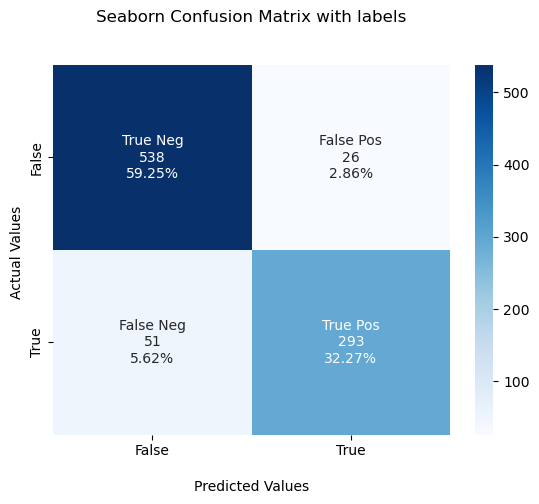

In [28]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cnf.flatten()/np.sum(cnf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

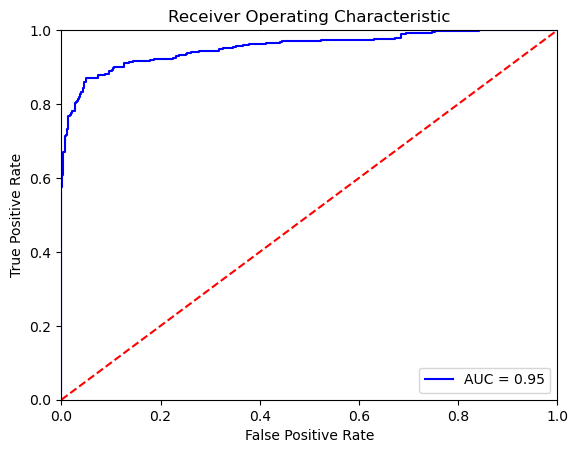

In [29]:

# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

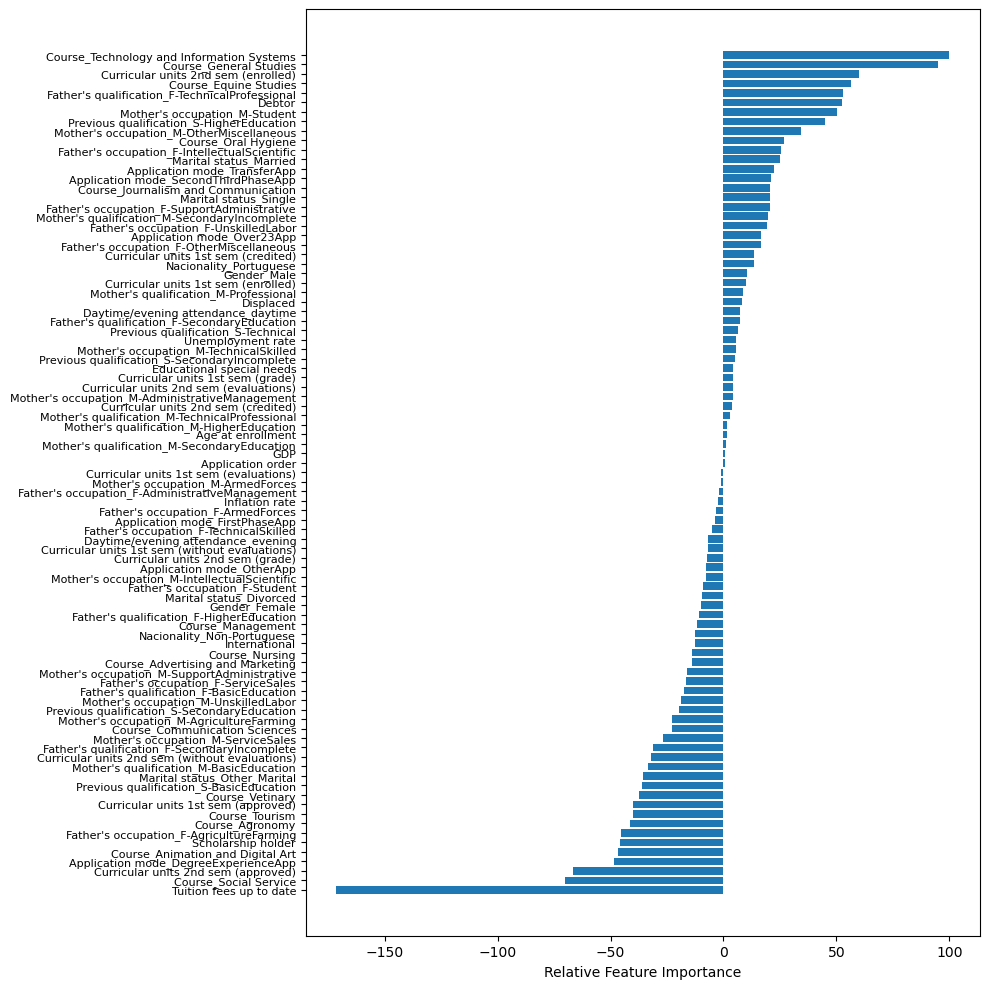

In [30]:
#Feature Importance
# Get the feature importance from the classifier
feature_importance = logreg.coef_[0]

# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
featfig = plt.figure(figsize=(10, 10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.tight_layout()
plt.show()

#### Odds Ratio

An OR expresses the relative change in the odds of an event occurring for a unit increase in a predictor variable, holding all other variables constant.

2. Interpretation:

OR > 1: Indicates a positive association. The odds of the event increase as the predictor variable increases.
OR < 1: Indicates a negative association. The odds of the event decrease as the predictor variable increases.
OR = 1: Indicates no association between the predictor variable and the event.
3. Magnitude:

The magnitude of the OR indicates the strength of the association:

OR close to 1: Weak association.
OR moderate distance from 1: Moderate association.
OR far from 1: Strong association.
4. Example:

An OR of 2.5 for exposure to a certain chemical and developing a disease means the odds of developing the disease are 2.5 times higher for those exposed compared to those not exposed.

In [44]:
#Odd Ratios
# Get Odds ratio and p-values

odd_ratio = np.exp(logreg.coef_[0])
p_values = pd.DataFrame(np.round(logreg.coef_, 4), columns=X_train.columns.values).T  

In [45]:
p_values['Odd Ratio'] = odd_ratio
p_values.rename(columns={0: 'Coefficient'}, inplace=True)
p_values.sort_values(by='Odd Ratio', ascending=False, inplace=True)


In [48]:
p_values.head()

,Coefficient,Odd Ratio
Course_Technology and Information Systems,1.4876,4.426634
Course_General Studies,1.4139,4.112096
Curricular units 2nd sem (enrolled),0.8955,2.448648
Course_Equine Studies,0.8417,2.320373
Father's qualification_F-TechnicalProfessional,0.7857,2.193876


Summary: 

Students who enroll in Tech courses in the university are 4.4 times as likely to drop out than other students all other things being equal.

##### Results:

The Logistic regression model is highly accurate, with excellent precision and recall. Next steps are to 1. evaluate the stability of the model by using cross-validation, 2. Evaluate if model is overfitting, 3. Test other models, 4. LIME SHAP

In [27]:
## TO DO: convert the below to a clean summary markdown cell

#accuracy is defined as the number of correct predictions divided by the total number of predictions
#precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. 
#recall is defined as the number of true positives divided by the number of true positives plus the number of false negatives.
#F1 score is defined as the harmonic mean of precision and recall.
#ROC curve is a plot of the true positive rate against the false positive rate for the different possible cutpoints of a diagnostic test.
#AUC is the area under the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

#Accuracy is the probability that a sample is classified correctly.
#Precision, in other words, is the probability that a sample classified as positive is actually positive.
#Recall is the probability that a positive sample is classified as positive.
#F1 score is the harmonic mean of precision and recall.
#ROC, in otherwords, is the probability that a positive sample is classified as positive and a negative sample is classified as negative.


# Precision is the probability that a predicted positive is actually positive.
# Recall is the probability that an actual positive is predicted positive.

#For example, if a model predicts that 10 emails are spam, and 5 of those emails are actually spam, then the model's precision is 50%. 
#This means that the model is correct half of the time when it predicts that an email is spam.

#For example, if there are 100 spam emails in a dataset, and a model identifies 80 of them, then the model's recall is 80%. 
#This means that the model found 80% of the actual spam emails in the dataset.

#The F1 score is a good measure to use when the cost of false positives and false negatives is the same. 
#For example, the F1 score is often used to evaluate the performance of spam filters.


In [28]:
##Next Steps: Cross-Validation 
##Next Steps: Feature Selection 
##Next Steps: Hyperparameter Tuning 
##Next Steps: Ensemble Methods 
##Next Steps: Model Evaluation 
## Model Deployment 
